# Data Analysis of bolt demand data

In [19]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np

import h3
import folium
from folium.plugins import HeatMap

from shapely.geometry import Polygon
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex

In [ ]:
# variables
INPUT_FILE_PATH = '../processed_data/bolt_demand.pickle'
# resolution 6: area ~ 36 129 062 m2 radius ~ 3724 m
# resolution 7: area ~ 5 161 293 m2 radius ~ 1406 m
# reosultion 8: area ~ 737 327 m2 radius ~ 530 m
# resolution 9: area ~ 105 332 m2 radius ~ 200 m
H3_RESOLUTION_GRID = 8
H3_RESOLUTION_COMMUNTIY = 6
STUTTGART_BOUNDS = [9.045, 48.7, 9.28, 48.86]

In [21]:
df = pd.read_pickle(INPUT_FILE_PATH)
df.head()

bike_id        lat       lon  \
0  BLT:Vehicle:b6069f5c-58b8-4f69-9671-94b88988d4a0  48.708420  9.003853   
1  BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b  48.826118  9.238379   
2  BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e  48.748035  9.074088   
3  BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870  48.809673  9.183686   
4  BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5  48.741364  9.165754   

   current_range_meters  current_fuel_percent event_type  \
0               10080.0                  0.39     pickup   
1               23800.0                  0.44     pickup   
2               22400.0                  0.42     pickup   
3               14000.0                  0.30     pickup   
4               46900.0                  0.77     pickup   

  event_time_start_range event_time_end_range  
0    2025-02-11 14:39:37  2025-02-11 14:44:37  
1    2025-02-11 14:39:37  2025-02-11 14:44:37  
2    2025-02-11 14:39:37  2025-02-11 14:44:37  
3    2025-02-11 14:39:37  2025-02-11 14:44:37  
4    2025-02-11 14:39:37  2025-02-11 14:44:37

In [22]:
# filter for Stuttgart
df = df[(df['lat'] > STUTTGART_BOUNDS[1]) & (df['lat'] < STUTTGART_BOUNDS[3]) & (df['lon'] > STUTTGART_BOUNDS[0]) & (df['lon'] < STUTTGART_BOUNDS[2])]
len(df)

377016

In [23]:
df['geometry'] = gpd.points_from_xy(df['lon'], df['lat'], crs="EPSG:4326")
df['grid_index'] = df.apply(lambda x: h3.latlng_to_cell(x['lat'], x['lon'], H3_RESOLUTION_GRID), axis=1)
df['community_index'] = df.apply(lambda x: h3.latlng_to_cell(x['lat'], x['lon'], H3_RESOLUTION_COMMUNTIY), axis=1)
# timestamp as mean of start range and end range
df['timestamp'] = pd.to_datetime(
    (df['event_time_start_range'].view(np.int64) + df['event_time_end_range'].view(np.int64)) // 2
)
df.drop(columns=['event_time_start_range', 'event_time_end_range'], inplace=True)
df.drop(columns=['lon', 'lat'], inplace=True)
df = gpd.GeoDataFrame(df, geometry='geometry')
df.head()

/tmp/ipykernel_332103/3711545904.py:6: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  (df['event_time_start_range'].view(np.int64) + df['event_time_end_range'].view(np.int64)) // 2


bike_id  current_range_meters  \
1  BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b               23800.0   
2  BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e               22400.0   
3  BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870               14000.0   
4  BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5               46900.0   
5  BLT:Vehicle:e1c6c470-1032-4ea6-94b6-e69de8492a97               35000.0   

   current_fuel_percent event_type                  geometry       grid_index  \
1                  0.44     pickup  POINT (9.23838 48.82612)  891faa718b3ffff   
2                  0.42     pickup  POINT (9.07409 48.74804)  891faa7b137ffff   
3                  0.30     pickup  POINT (9.18369 48.80967)  891faa71327ffff   
4                  0.77     pickup  POINT (9.16575 48.74136)  891faa78cc3ffff   
5                  0.60     pickup  POINT (9.18678 48.78089)  891faa7a8a7ffff   

   community_index           timestamp  
1  861faa71fffffff 2025-02-11 14:42:07  
2  861faa787ffffff 2025-02-11 14:42:07  
3  861faa717ffffff 2025-02-11 14:42:07  
4  861faa78fffffff 2025-02-11 14:42:07  
5  861faa7afffffff 2025-02-11 14:42:07

## Temporal time bining

In [24]:
time_bins = [0, 5, 9, 13, 20]
time_labels = ['morning', 'midday', 'afternoon', 'evening']
df['time_bin'] = pd.cut(df['timestamp'].dt.hour, bins=time_bins, labels=time_labels, right=False)

In [25]:
pickup_demand = df[df['event_type'] == "pickup"].copy()
dropoff_demand = df[df['event_type'] == "dropoff"].copy()
pickup_demand.drop(columns=['event_type'], inplace=True)
dropoff_demand.drop(columns=['event_type'], inplace=True)
len(pickup_demand), len(dropoff_demand)

(188497, 188519)

In [26]:
pickup_demand['grid_index'].nunique()

1072

In [27]:
# display pickup demand as a heatmap based on the h3 index
def display_as_heatmap(temp_df): 
    grid_counts = temp_df['grid_index'].value_counts().reset_index()
    grid_counts.columns = ['grid_index', 'count']

    grid_polygons = []
    for idx in grid_counts['grid_index']:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts, 
        geometry=[
            Polygon([(p[1], p[0]) for p in poly]) 
            for poly in grid_polygons
        ],
        crs="EPSG:4326"
    )

    # Calculate map boundaries
    bounds = grid_gdf.total_bounds  # [minx, miny, maxx, maxy]
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    # Create a non-interactive map
    m_pickup = folium.Map(location=[mean_lat_pickup, mean_lon_pickup], no_touch=True, dragging=False, zoom_control=False)

    def get_color(count, max_count):
        norm = Normalize(vmin=0, vmax=max_count ** 0.9)
        colormap = cm.get_cmap('viridis')
        rgba_color = colormap(norm(count))
        return to_hex(rgba_color)

    max_count = grid_gdf['count'].max()

    # Add hexagons to map
    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row['count']: {
                'fillColor': get_color(count, max_count),
                'color': 'transparent',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"Count: {row['count']}, Grid Index: {row['grid_index']}"
        ).add_to(m_pickup)

    community_counts = temp_df['community_index'].value_counts().reset_index()
    community_counts.columns = ['community_index', 'count']
    community_counts['cell_count'] = temp_df.groupby('community_index')['grid_index'].transform('nunique')
    community_counts = community_counts[community_counts['count'] > 50]

    community_polygons = []
    for idx in community_counts['community_index']:
        polygon_geojson = h3.cell_to_boundary(idx)
        community_polygons.append(polygon_geojson)
    
    community_gdf = gpd.GeoDataFrame(
        community_counts, 
        geometry=[
            Polygon([(p[1], p[0]) for p in poly]) 
            for poly in community_polygons
        ],
        crs="EPSG:4326"
    )

    # Add community polygons to map
    for idx, row in community_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x: {
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0
            },
            tooltip=f"Community Index : {row['community_index']}, Count: {row['count']}, Cell Count: {row['cell_count']}"
        ).add_to(m_pickup)

    # Fit map to bounds
    m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    print(f"Map bounds: {bounds}")

    return m_pickup

In [28]:
display_as_heatmap(pickup_demand)

/tmp/ipykernel_332103/128633210.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


Map bounds: [ 9.06511154 48.70095055  9.27867108 48.85304284]


/tmp/ipykernel_332103/128633210.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [29]:
display_as_heatmap(dropoff_demand)

/tmp/ipykernel_332103/128633210.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


Map bounds: [ 9.06511154 48.70095055  9.27867108 48.85304284]


/tmp/ipykernel_332103/128633210.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


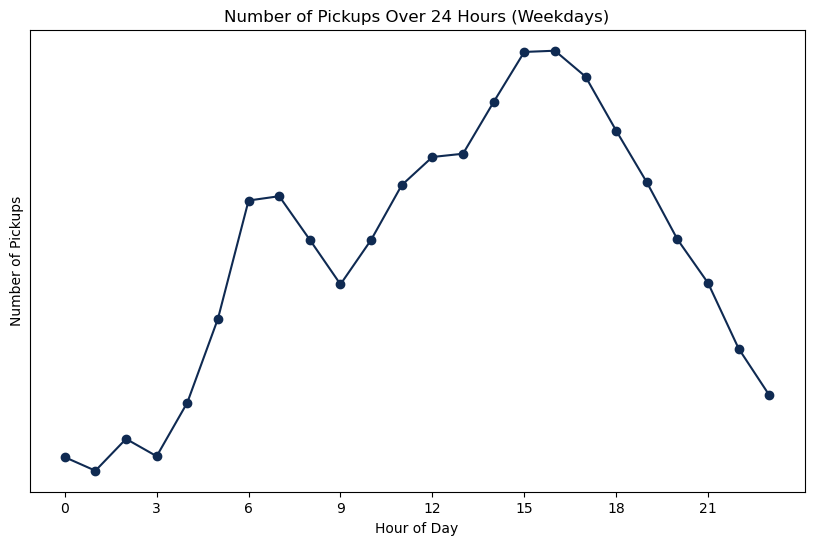

In [30]:
# Group by hour and count pickups
pickup_hourly_weekday = pickup_demand[pickup_demand['timestamp'].dt.dayofweek < 5]['timestamp'].dt.hour.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(pickup_hourly_weekday.index, pickup_hourly_weekday.values, marker='o', linestyle='-', color='#0F2A52')
plt.title('Number of Pickups Over 24 Hours (Weekdays)')
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.show()

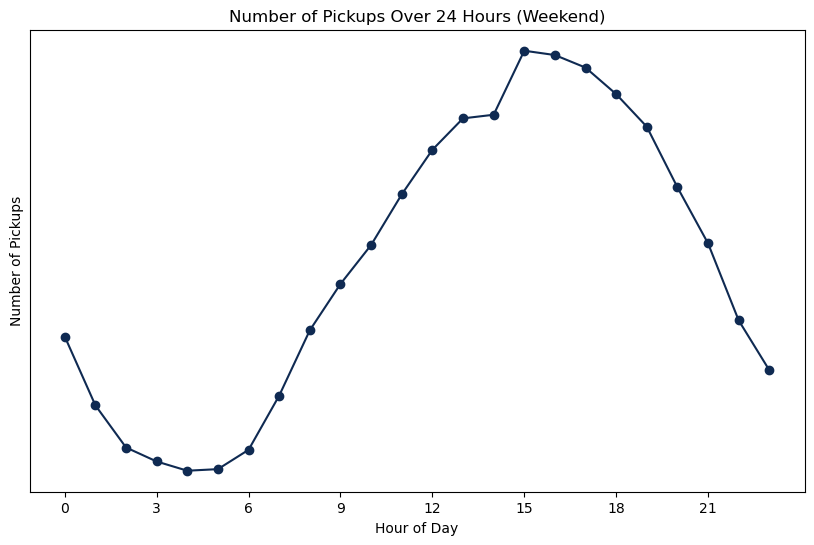

In [31]:
pickup_hourly_weekend = pickup_demand[pickup_demand['timestamp'].dt.dayofweek >= 5]['timestamp'].dt.hour.value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(pickup_hourly_weekend.index, pickup_hourly_weekend.values, marker='o', linestyle='-', color='#0F2A52')
plt.title('Number of Pickups Over 24 Hours (Weekend)')
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.show()

In [32]:
# Aggregate data hourly and for each grid cell (pickups and dropoffs)
pickup_hourly = pickup_demand.groupby([pickup_demand['timestamp'].dt.hour, 'grid_index']).size().reset_index()
pickup_hourly.columns = ['hour', 'grid_index', 'pickup_count']

dropoff_hourly = dropoff_demand.groupby([dropoff_demand['timestamp'].dt.hour, 'grid_index']).size().reset_index()
dropoff_hourly.columns = ['hour', 'grid_index', 'dropoff_count']

rebalance_data = pd.merge(pickup_hourly, dropoff_hourly, on=['hour', 'grid_index'], how='outer').fillna(0)
rebalance_data['imbalance'] = rebalance_data['pickup_count'] - rebalance_data['dropoff_count']

# Aggregate by hour
rebalance_data_aggregated = rebalance_data.groupby('hour').agg({
    'imbalance': 'sum'
}).reset_index()

rebalance_data.head()

hour       grid_index  pickup_count  dropoff_count  imbalance
0     0  891faa6300bffff           3.0            1.0        2.0
1     0  891faa63013ffff           1.0            0.0        1.0
2     0  891faa63023ffff          12.0            6.0        6.0
3     0  891faa63027ffff           0.0            3.0       -3.0
4     0  891faa6302bffff           3.0            0.0        3.0

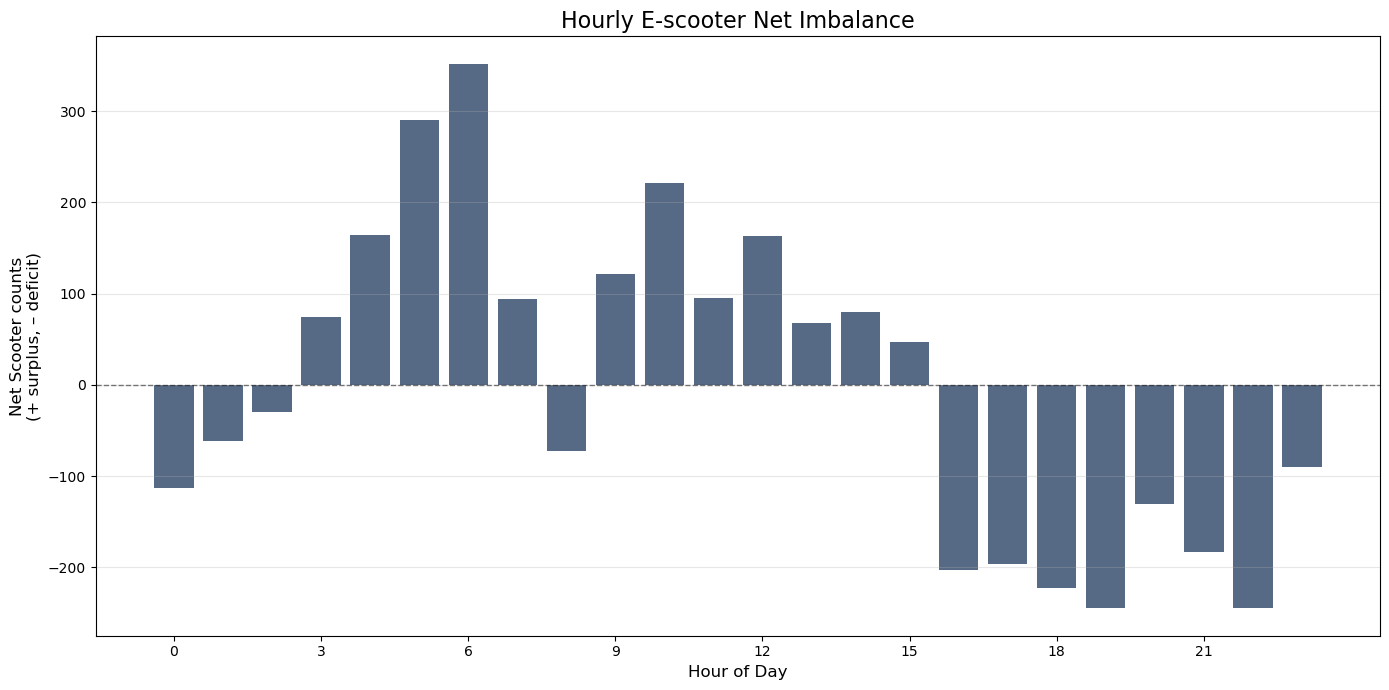

In [33]:
# Draw imbalance hourly
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(
    rebalance_data_aggregated['hour'],
    rebalance_data_aggregated['imbalance'],
    width=0.8,
    label='Net Imbalance (Pickups – Dropoffs)',
    color='#0F2A52',
    alpha=0.7
)

ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Net Scooter counts\n(+ surplus, – deficit)', fontsize=12)
ax.set_xticks(range(0, 24, 3))
ax.grid(axis='y', alpha=0.3)

plt.title('Hourly E-scooter Net Imbalance', fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
# display pickup demand as a heatmap based on the h3 index
import branca

def display_imbalance_as_heatmap(temp_df, rebalance_data): 
    grid_counts = rebalance_data.groupby('grid_index')['imbalance'].agg('sum').reset_index()
    grid_counts.columns = ['grid_index', 'imbalance']

    grid_polygons = []
    for idx in grid_counts['grid_index']:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts, 
        geometry=[
            Polygon([(p[1], p[0]) for p in poly]) 
            for poly in grid_polygons
        ],
        crs="EPSG:4326"
    )

    bounds = grid_gdf.total_bounds  # [minx, miny, maxx, maxy]
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    m_pickup = folium.Map(location=[mean_lat_pickup, mean_lon_pickup],
        tiles='Cartodb Positron')

    def get_color(count, max_abs):
        # red means deficit, blue means surplus
        cmap = branca.colormap.LinearColormap(
        colors=['blue','white','red'],
        vmin=-max_abs, vmax=+max_abs,
        caption='Net Imbalance (pickups – dropoffs)'
    ).to_step(10) 
        rgba = cmap(count)
        return to_hex(rgba)

    max_abs = grid_gdf['imbalance'].abs().max()

    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row['imbalance']: {
                'fillColor': get_color(count, max_abs),
                'color': 'transparent',
                'weight': 1,
                'fillOpacity': 0.7
            },
            tooltip=f"Imbalance: {row['imbalance']}, Grid Index: {row['grid_index']}"
        ).add_to(m_pickup)

    m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

    return m_pickup

# Draw imbalance on a map
Red cells are areas where more pick-up events happen than drop-offs

## Imbalance in the morning peak

In [35]:
display_imbalance_as_heatmap(pickup_demand, rebalance_data[(rebalance_data['hour'] >= 3) & (rebalance_data['hour'] < 8)])

## Imbalance at evening peak

In [36]:
display_imbalance_as_heatmap(pickup_demand, rebalance_data[(rebalance_data['hour'] >= 15) & (rebalance_data['hour'] < 20)])